Calibrating the MPU-6050
----

> Note: this notebook is part of this blog post [here](https://www.stupid-projects.com/controlling-a-3d-object-in-unity3d-with-teensy-and-mpu-6050/)

The [MPU-6050](https://www.invensense.com/products/motion-tracking/6-axis/mpu-6050/) is a 6-axis (3-axis Gyro + 3-axis Accelerometer) MEMS motion tracking device with an onboard module called Digital Motion Processor (DMP). DMP can be used to implement complex calculations on the device.

In order to calibrate it you can just use the Arduino firmware in `mpu6050-calibration/mpu6050-raw-calibration/mpu6050-raw-calibration.ino` and avoid the hassle, but if you want to use a PID controller to get the calibration data, then you use the firmware in `mpu6050-calibration/mpu6050-pid-calibration/mpu6050-pid-calibration.ino` and this notebook.



## Collect samples

Load the `mpu6050-raw-calibration.ino` on Arduino IDE and open the `Serial Monitor` from the `Tools` menu. Then build and flash the firmware and let it run and collect a quite large number of samples. Then copy those samples from the serial monitor and paste them to a new file called `calibration_data.txt`. Make sure that there is no empty line in the end of the file, otherwise the following code will file. After you save the file, place it in the same folder with this notepad and then start running the cells.

In [39]:
import numpy as np
import matplotlib.pyplot as plt

In [40]:
# Read file into an array of values
calibration_file = 'calibration_data.txt'
data = []
with open(calibration_file) as f:
    lines = f.read().splitlines()
    AccX = [float(line.split(',')[0]) for line in lines]
    AccXoffset = [float(line.split(',')[1]) for line in lines]
    AccY = [float(line.split(',')[2]) for line in lines]
    AccYoffset = [float(line.split(',')[3]) for line in lines]
    AccZ = [float(line.split(',')[4]) for line in lines]
    AccZoffset = [float(line.split(',')[5]) for line in lines]
    
    GyrX = [float(line.split(',')[6]) for line in lines]
    GyrXoffset = [float(line.split(',')[7]) for line in lines]
    GyrY = [float(line.split(',')[8]) for line in lines]
    GyrYoffset = [float(line.split(',')[9]) for line in lines]
    GyrZ = [float(line.split(',')[10]) for line in lines]
    GyrZoffset = [float(line.split(',')[11]) for line in lines]

n_samples = len(AccX)
print('Number of samples:', n_samples)

Number of samples: 445


## Accelerator calibration
The following cell will display the data that the tool collected. Notice that the first data are way off as the PID controller tries to correct the error between the input and output. Therefore, use the `skip_first_n_data` value to skip the first data.

In [52]:
skip_first_n_data = 100     # This will skip the first number of data

In [54]:
print('AccX offset avg: ', np.mean(AccXoffset[skip_first_n_data:]))
print('AccY offset avg: ', np.mean(AccYoffset[skip_first_n_data:]))
print('AccZ offset avg: ', np.mean(AccZoffset[skip_first_n_data:]))
print('GyrX avg: ', np.mean(GyrXoffset[skip_first_n_data:]))
print('GyrY avg: ', np.mean(GyrYoffset[skip_first_n_data:]))
print('GyrZ avg: ', np.mean(GyrZoffset[skip_first_n_data:]))

AccX offset avg:  1336.8466666666666
AccY offset avg:  -3458.2886956521743
AccZ offset avg:  1345.697391304348
GyrX avg:  -41.72231884057971
GyrY avg:  27.67623188405797
GyrZ avg:  23.045797101449278


## Source code values
Run the next cell and copy/paste the output in your `setCalibrationValues()` function in the `teensy-motion-hid/teensy-motion-hid.ino` file. Note, that these are the integer values as the t

In [42]:
print('mpu.setXAccelOffset(%d);' % np.mean(AccXoffset[avg_start_index:]))
print('mpu.setYAccelOffset(%d);' % np.mean(AccYoffset[avg_start_index:]))
print('mpu.setZAccelOffset(%d);' % np.mean(AccZoffset[avg_start_index:]))
print('mpu.setXGyroOffset(%d);' % np.mean(GyrXoffset[avg_start_index:]))
print('mpu.setYGyroOffset(%d);' % np.mean(GyrYoffset[avg_start_index:]))
print('mpu.setZGyroOffset(%d);' % np.mean(GyrZoffset[avg_start_index:]))

mpu.setXAccelOffset(1336);
mpu.setYAccelOffset(-3458);
mpu.setZAccelOffset(1345);
mpu.setXGyroOffset(-41);
mpu.setYGyroOffset(27);
mpu.setZGyroOffset(23);


## Plot the PID output
It's interesting to plot the calibration data that the PID firmware produces and see how the PID tries to stabize the output.

Also try to change the `data_start_offset` and `data_end_offset` values to get a more detailed view in data by zoomin-in and out. Those values are actually select a subset of the data, by starting from `data_start_offset` and ending `data_end_offset` inside the data buffer for each component (AccX, AccY e.t.c.).

The default values are:
```py
data_start_offset = 0
data_end_offset = n_samples
```

Because in the first samples the PID controller correct the output fast as the error is big, then if you use the default values you'll just get a big slope. So, try these examples in this notebook:

data_start_offset | data_end_offset
-|-
0 | n_samples
0 | 20
0 | 50
0 | 100
20 | n_samples



In [49]:
data_start_offset = 0
data_end_offset = n_samples

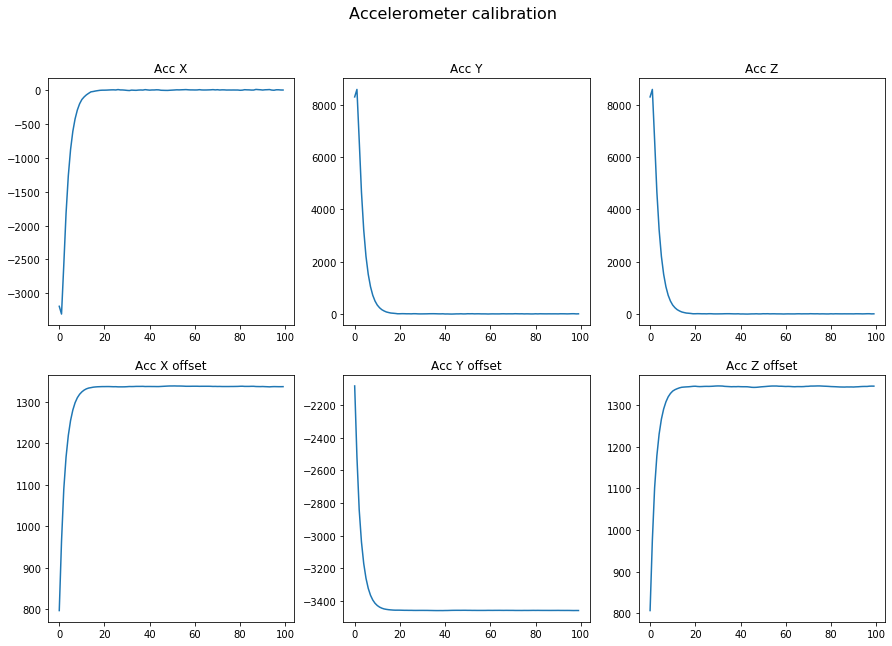

In [47]:
x = range(0, data_end_offset - data_start_offset)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Accelerometer XYZ
y = AccX[data_start_offset:data_end_offset]
axs[0, 0].plot(x,y)
axs[0, 0].set_title('Acc X')

y = AccY[data_start_offset:data_end_offset]
axs[0, 1].plot(x,y)
axs[0, 1].set_title('Acc Y')

y = AccY[data_start_offset:data_end_offset]
axs[0, 2].plot(x,y)
axs[0, 2].set_title('Acc Z')

# Accelerometer offset XZY
y = AccXoffset[data_start_offset:data_end_offset]
axs[1, 0].plot(x,y)
axs[1, 0].set_title('Acc X offset')

y = AccYoffset[data_start_offset:data_end_offset]
axs[1, 1].plot(x,y)
axs[1, 1].set_title('Acc Y offset')

y = AccZoffset[data_start_offset:data_end_offset]
axs[1, 2].plot(x,y)
axs[1, 2].set_title('Acc Z offset')


fig.suptitle('Accelerometer calibration', fontsize=16)
plt.show()

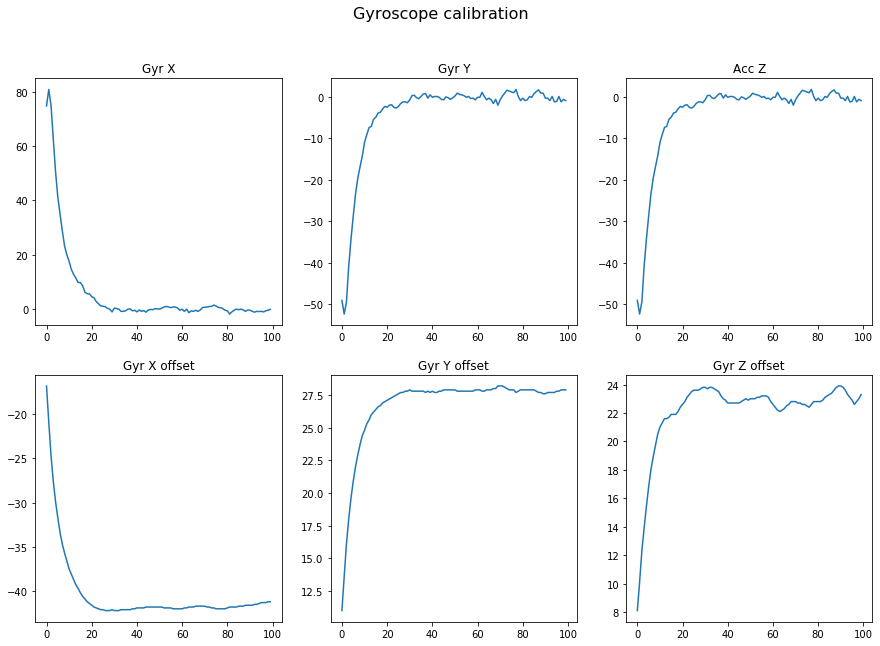

In [48]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Accelerometer XYZ
y = GyrX[data_start_offset:data_end_offset]
axs[0, 0].plot(x,y)
axs[0, 0].set_title('Gyr X')

y = GyrY[data_start_offset:data_end_offset]
axs[0, 1].plot(x,y)
axs[0, 1].set_title('Gyr Y')

y = GyrY[data_start_offset:data_end_offset]
axs[0, 2].plot(x,y)
axs[0, 2].set_title('Acc Z')

# Accelerometer offset XZY
y = GyrXoffset[data_start_offset:data_end_offset]
axs[1, 0].plot(x,y)
axs[1, 0].set_title('Gyr X offset')

y = GyrYoffset[data_start_offset:data_end_offset]
axs[1, 1].plot(x,y)
axs[1, 1].set_title('Gyr Y offset')

y = GyrZoffset[data_start_offset:data_end_offset]
axs[1, 2].plot(x,y)
axs[1, 2].set_title('Gyr Z offset')


fig.suptitle('Gyroscope calibration', fontsize=16)
plt.show()